In [3]:
import gym
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

In [4]:
from gym.wrappers import Monitor

env = gym.make("MontezumaRevenge-v0")
env = Monitor(env, './video', force=True)


In [355]:
done = False
env.reset()
while not done:
    a = env.action_space.sample()
    s, r, done, info = env.step(a)

show_video()

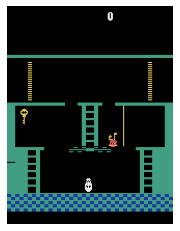

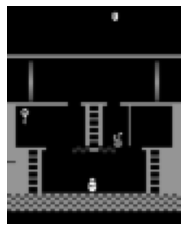

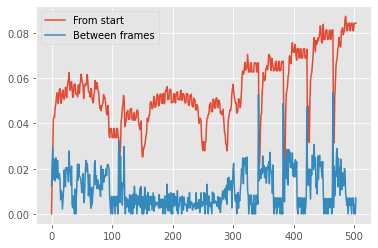

In [593]:
from gym.wrappers import Monitor
import numpy as np
from skimage.transform import rescale, resize
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity
 

env = gym.make("MontezumaRevenge-v0")
env = Monitor(env, './video', force=True)
lores = lambda x: resize(rgb2gray(x), (100, 80))


done = False
s = env.reset()
s0 = s
im0 = lores(s0)

sim1 = []
sim2 = []
i = 0
while not done:
    a = env.action_space.sample()
    next_s, r, done, info = env.step(a)
    im1 = lores(s)
    im2 = lores(next_s)
    # print(structural_similarity(im0, im1), structural_similarity(im1, im2))
    sim1.append(1 - structural_similarity(im0, im1))
    sim2.append(1 - structural_similarity(im1, im2))
    s = next_s
    i+=1
    if i > 1000:
        break

plt.axis('off')
plt.imshow(s)
plt.show()

plt.axis('off')
plt.imshow(lores(s), cmap='gray')
plt.show()

plt.plot(np.arange(len(sim1)), sim1, label='From start')
plt.plot(np.arange(len(sim2)), sim2, label='Between frames')
plt.legend(loc="upper left")
plt.show()

# DQN

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
import random

BATCH_SIZE = 128 # 128
UPDATE_STEP = 4 # 4
BUFFER_SIZE = 100000 # 100000
LEARNING_RATE = 1e-3 # 5e-3
GAMMA = 0.9 # 0.9
EPS_START = 1 # 1
EPS_END = 0.1 # 0.1
EPS_DECAY = 0.995 # 0.995
TAU=1e-3 # 1e-3

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))

    
class MasterNetwork(nn.Module):
    """
    Simple multilayer network for DQN agent
    """

    def __init__(self, state_size,  emb_size, seed=42, hidden_size1=64, hidden_size2=64):
        super(MasterNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.layer1 = nn.Linear(state_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, emb_size)

    def forward(self, goal_states):
        x = F.relu(self.layer1(goal_states))
        x = F.relu(self.layer2(x))
        return torch.sigmoid(self.layer3(x))
    
class WorkerNetwork(nn.Module):
    """
    Simple multilayer network for DQN agent
    """

    def __init__(self, state_size, action_size, emb_size, seed=42, hidden_size1=64, hidden_size2=64):
        super(WorkerNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)    
        self.layer1 = nn.Linear(state_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.layer3 = nn.Linear(emb_size + hidden_size2, hidden_size2)
        self.layer4 = nn.Linear(hidden_size2, action_size)

    def forward(self, states, embs):
        x = F.relu(self.layer1(states))
        x = F.relu(self.layer2(x))
        x = torch.cat((embs, x), 1)
        x = F.relu(self.layer3(x))
        return self.layer4(x)  
    

class MasterWorkerNetwork(nn.Module):
    """
    Master-Worker model
    """
    
    def __init__(self, state_size, action_size, emb_size=64, seed=42):
        super(MasterWorkerNetwork, self).__init__()
        self.master = MasterNetwork(state_size, emb_size)
        self.worker = WorkerNetwork(state_size, action_size, emb_size)
        
    def forward(self, states, goal_states):
        embs = self.master.forward(goal_states)
        return self.worker.forward(states, embs)


class DQNAgentGoal:
    """ An agent implementing Deep Q-Network algorithm"""
    
    def __init__(self, state_size, action_size, emb_size=64, seed=42):
        """Initializes an Agent.
        
        Params:
        -------
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.qnetwork_local = MasterWorkerNetwork(state_size, action_size, emb_size).to(device)
        self.qnetwork_target = MasterWorkerNetwork(state_size, action_size, emb_size).to(device)
        self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LEARNING_RATE)
        self.action_size = action_size
        self.buffer = deque(maxlen=BUFFER_SIZE) 
        self.step = 0
        self.eps = EPS_START
        self.explore = True
        
        
    def freeze_worker(self, learning_rate=LEARNING_RATE):
        for param in self.qnetwork_local.worker.parameters():
            param.requires_grad = False
            
        trainable = filter(lambda p: p.requires_grad, self.qnetwork_local.parameters())
        optimizer = optim.Adam(trainable, lr=learning_rate)
            
   
    def reset_episode(self):
        """
        Resets episode and update epsilon decay
        """
        self.eps = max(EPS_END, EPS_DECAY*self.eps) 
        
    def encode(self, raw_state):
        return resize(rgb2gray(raw_state), (100, 80)).flatten()
        
        
    def learn(self):
        """
        Learns values-actions network
        
        """
        
        # Sample batch from replay buffer
        states, next_states, goal_states, actions, rewards, dones = self.sample_batch()
        
        values = self.qnetwork_target.forward(next_states, goal_states).detach()
        targets = rewards + GAMMA * values.max(1)[0].view(dones.size()) * (1 - dones)
        outputs = self.qnetwork_local.forward(states, goal_states).gather(1, actions.long())
        self.optimizer.zero_grad()
        loss = F.mse_loss(outputs, targets)
        loss.backward()
        self.optimizer.step()
    
    
    def update(self, state, goal_state, action, reward, next_state, done):
        """
        Makes an update step of algorithm and append sars to buffer replay
        
        Params:
        -------
        state - current state
        action - action made
        reward - reward for an action
        next_state - next state from env
        done - episode finishing flag
        """
        state = self.encode(state)
        goal_state = self.encode(goal_state)
        next_state = self.encode(next_state)
        
        self.buffer.append((state, next_state, goal_state, action, reward, float(done)))
        
        self.step = (self.step+1)%UPDATE_STEP
        if self.step == 0:
            if len(self.buffer) > BATCH_SIZE:
                self.learn()
                self.reset_target_network()
        
        
    def reset_target_network(self):
        """
        Resets params of target network to values from local network
        """
        params = zip(self.qnetwork_target.parameters(), self.qnetwork_local.parameters())
        for target_param, local_param in params:
            updated_params = TAU*local_param.data + (1-TAU)*target_param.data
            target_param.data.copy_(updated_params)
        
        
    def act(self, state, goal_state):
        """
        Selects action from state if epsilon-greedy way
        
        Params:
        state - current state
        
        """
        
        state = self.encode(state)
        goal_state = self.encode(goal_state)
        
        self.step+=1
        
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(torch.from_numpy(np.vstack([state])).float().to(device), 
                                                torch.from_numpy(np.vstack([goal_state])).float().to(device))  
        self.qnetwork_local.train()
            
        if (random.random() > self.eps) and self.explore:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def sample_batch(self):
        """
        Samples a batch of experience from replay buffer random uniformily
        """
        batch = random.sample(self.buffer, k=BATCH_SIZE)
        f = lambda arr: torch.from_numpy(np.vstack(arr)).float().to(device)
        states, next_states, goal_states, actions, rewards, dones = map(f, zip(*batch))
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        return states, next_states, goal_states, actions, rewards, dones

Running on device: cpu


# From buffer 

In [6]:
import sys
sys.path.append('..')

from gym_minigrid_navigation.utils import show_video

In [9]:
from collections import deque
import random
import numpy as np
from skimage.transform import rescale, resize
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity

class FromBufferGoalWrapper(gym.Wrapper):
       
    def __init__(self, env, verbose=False):
        self.buffer = deque(maxlen=1000)
        self.goal_state = None
        self.step_count = 0
        self.max_steps = 1000
        self.verbose = verbose
        super().__init__(env)
    
    def reset(self):
        
        # Generate goal state
        self.step_count = 0
        if len(self.buffer) > 100:
            self.goal_state = random.sample(self.buffer, k=1)[0]
        
        return self.env.reset()

        
    def step(self, action):

        state = self.env.unwrapped._get_obs()
        
        next_state, reward, done, info = self.env.step(action)
        self.buffer.append(next_state)       
        
        if self.goal_state is None:
            dist = 1
        else:
            lores = lambda x: resize(rgb2gray(x), (20, 15))
            dist = 1 - structural_similarity(lores(next_state), lores(self.goal_state))
        
        if dist < 0.005:
            reward = reward if reward > 0 else (1 - 1/self.max_steps * self.step_count)
            done = True
            if self.verbose:
                print("Goal achieved in {0} steps, reward: {1}, dist: {2}".format(self.step_count, reward, dist))
                               
        if self.step_count >= self.max_steps:
            if self.verbose:
                print("Maximums steps exceeded!", dist, self.step_count)
            done = True
            reward = -0.5
        else:
            if done and (reward == 0):
                reward = -1
                if self.verbose:
                    print("Episode failed!")
            
            
        if self.verbose and (self.goal_state is not None) and done:
            plt.subplot(1, 2, 1)
            plt.axis('off')
            plt.gca().set_title('Goal state')
            plt.imshow(self.goal_state)
            plt.subplot(1, 2, 2)
            plt.axis('off')
            plt.gca().set_title('Final state')
            plt.imshow(next_state)
            plt.show()
             
        self.step_count += 1
        
        return next_state, reward, done, info

In [849]:
from gym.wrappers import Monitor
from gym_minigrid_navigation.environments import FullyObsWrapper, FullyRenderWrapper, ImgObsWrapper
from utils import init_logger
from navigation_policy import run_episode, run_episodes

init_logger('montezuma_logger')

env = gym.make("MontezumaRevenge-v0")
env = FromBufferGoalWrapper(env)
env = Monitor(env, './video', force=True)

In [850]:
env.reset()
done = False
while not done:
    a = env.action_space.sample()
    next_s, r, done, info = env.step(a)

In [851]:
state_size = 100*80
agent = DQNAgentGoal(state_size, action_size=env.action_space.n)
scores, steps = run_episodes(env, agent, None, n_episodes=1000, verbose=10)

Episode: 10. Average score: -0.38. Average steps: 743.30
Episode: 20. Average score: -0.56. Average steps: 593.00
Episode: 30. Average score: -0.59. Average steps: 640.80
Episode: 40. Average score: -0.12. Average steps: 467.00
Episode: 50. Average score: -0.54. Average steps: 634.80
Episode: 60. Average score: -0.24. Average steps: 653.20
Episode: 70. Average score: -0.29. Average steps: 551.50
Episode: 80. Average score: -0.56. Average steps: 650.20
Episode: 90. Average score: -0.12. Average steps: 557.30
Episode: 100. Average score: -0.72. Average steps: 605.00
Episode: 110. Average score: -0.67. Average steps: 579.10
Episode: 120. Average score: -0.72. Average steps: 608.90
Episode: 130. Average score: -0.61. Average steps: 712.50
Episode: 140. Average score: -0.41. Average steps: 568.40
Episode: 150. Average score: -0.47. Average steps: 559.90
Episode: 160. Average score: 0.11. Average steps: 380.30
Episode: 170. Average score: -0.47. Average steps: 529.80
Episode: 180. Average sc

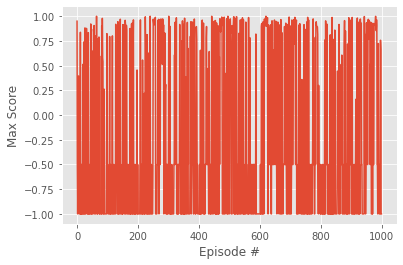

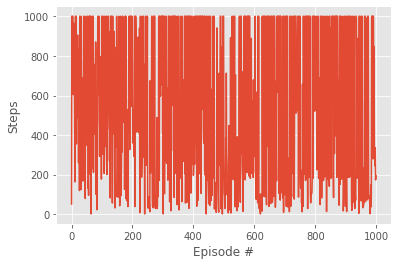

In [852]:
from utils import display_stats

display_stats(scores, steps)

Maximums steps exceeded! 1 1000
Goal achieved in 303 steps, reward: 0.6970000000000001, dist: 0.004781192164972414


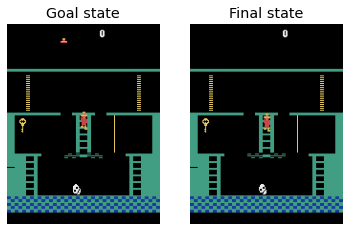

In [857]:
env = gym.make("MontezumaRevenge-v0")
env = FromBufferGoalWrapper(env, verbose=True)
env = Monitor(env, './video', force=True)

env.reset()
done = False
while not done:
    a = env.action_space.sample()
    next_s, r, done, info = env.step(a)

run_episode(env, agent, train_mode=False)

show_video()

# Verbose goal reaching

Episode failed!
Episode failed!


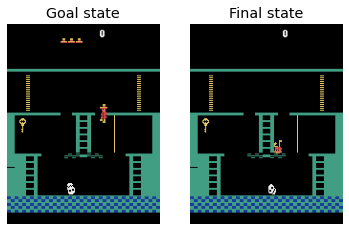

Episode failed!


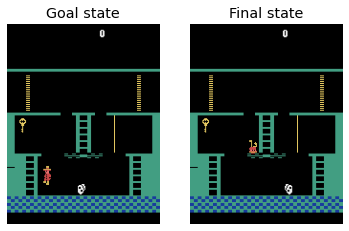

Episode failed!


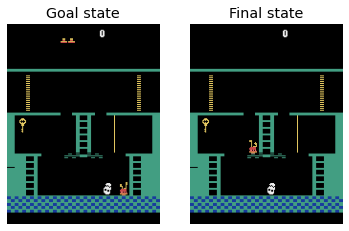

Goal achieved in 28 steps, reward: 0.972, dist: 0.0029950632398618726


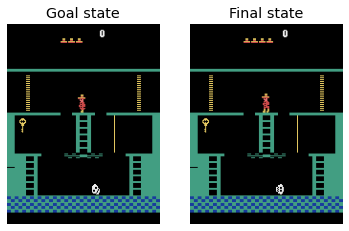

Goal achieved in 60 steps, reward: 0.94, dist: 0.004751091314126543


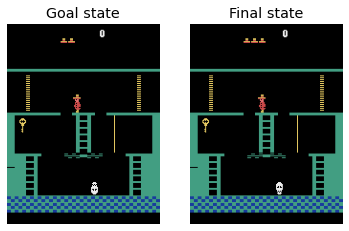

Goal achieved in 11 steps, reward: 0.989, dist: 2.4443545847629977e-05


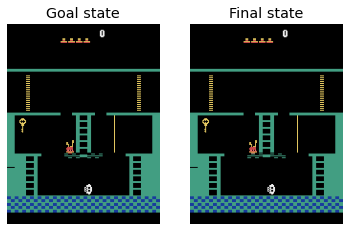

Episode failed!


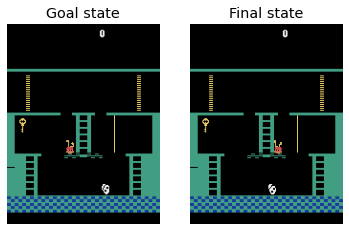

Goal achieved in 205 steps, reward: 0.7949999999999999, dist: 0.004625335016686938


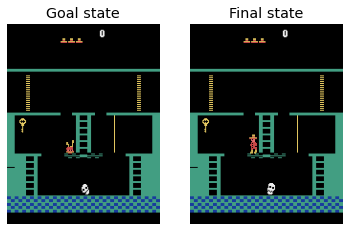

Maximums steps exceeded! 0.043850642307235566 1000


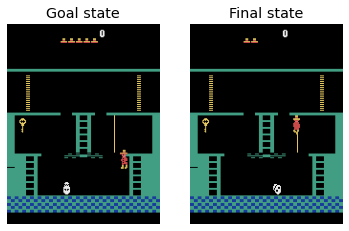

Episode failed!


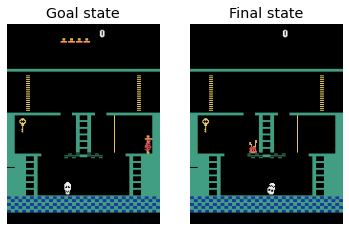

Episode: 10. Average score: -0.18. Average steps: 328.90


In [854]:
env = gym.make("MontezumaRevenge-v0")
env = FromBufferGoalWrapper(env, verbose=True)
env = Monitor(env, './video', force=True)

env.reset()
done = False
while not done:
    a = env.action_space.sample()
    next_s, r, done, info = env.step(a)

scores, steps = run_episodes(env, agent, None, n_episodes=10, verbose=10)

# Train predict next state

15


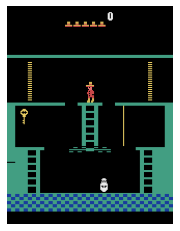

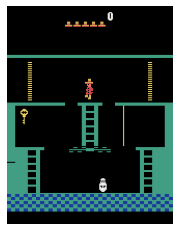

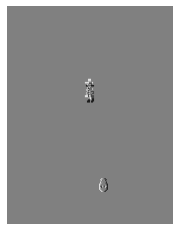

In [47]:
s = env.reset()
a = env.action_space.sample()
next_s, r, done, info = env.step(a)
print(a)
plt.axis('off')
plt.imshow(s)
plt.show()
plt.axis('off')
plt.imshow(next_s)
plt.show()
plt.axis('off')
ds = rgb2gray(next_s) - rgb2gray(s)
plt.imshow(ds, cmap='gray')
plt.show()

In [ ]:
class WorldNetwork(nn.Module):
    """
    Simple multilayer network for DQN agent
    """

    def __init__(self, state_size, action_size, emb_size, seed=42, hidden_size):
        super(WorldNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)    
        self.layer11 = nn.Linear(state_size, hidden_size)
        self.layer12 = nn.Linear(action_size, hidden_size) 
        self.layer2 = nn.Linear(2*hidden_size, hidden_size)
        self.layer3 = nn.Linear(state_size)

    def forward(self, states, action):
        x1 = F.relu(self.layer11(states))
        x2 = F.relu(self.layer12(actions))
        x = torch.cat((x1, x2), 1)
        x = F.relu(self.layer2(x))
        return self.layer3(x) 